In [9]:
import preproc_RNN_LSTM
import pandas as pd
import plot_evaluate_models
import matplotlib.pyplot as plt
from metrics import get_baseline_data
import numpy as np
import math
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from baseline import get_baseline_actual, get_baseline_predictions, forecast_accuracy
from preproc import get_format
# Import section
from datetime import datetime
from webbrowser import get
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from clean import clean_all, get_data, get_bairros_data

In [114]:
data

,Date,Anchieta,Bangu,Barra da Tijuca,Botafogo,Campo Grande,Centro,Cidade de Deus,Complexo do Alemao,Copacabana,...,Portuaria,Ramos,Realengo,Rio Comprido,Rocinha,Santa Cruz,Santa Teresa,Sao Cristovao,Tijuca,Vila Isabel
0,2008-12-31,0.025522,0.009079,0.011007,0.000000,0.010674,0.066617,0.000000,0.000000,0.034691,...,0.000000,0.006877,0.026449,0.015969,0.000000,0.002863,0.057947,0.052674,0.006297,0.000000
1,2009-01-01,0.063703,0.047398,0.052289,0.057072,0.066402,0.103458,0.198661,0.000000,0.070387,...,0.029703,0.062168,0.046459,0.114169,0.014499,0.062111,0.000000,0.072225,0.012807,0.053311
2,2009-01-02,0.031852,0.015799,0.010458,0.009512,0.045433,0.206917,0.000000,0.000000,0.056310,...,0.000000,0.034538,0.025811,0.016310,0.000000,0.028232,0.192864,0.018056,0.025613,0.038079
3,2009-01-03,0.006370,0.040626,0.017430,0.014268,0.027959,0.103458,0.198661,0.000000,0.042232,...,0.059406,0.041445,0.041297,0.048929,0.014499,0.014116,0.096432,0.054169,0.019210,0.015232
4,2009-01-04,0.006370,0.029341,0.006972,0.014268,0.033201,0.206917,0.099331,0.000000,0.035194,...,0.000000,0.034538,0.036135,0.114169,0.000000,0.042349,0.000000,0.126394,0.012807,0.007616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2019-12-26,0.063110,0.017175,0.026825,0.033151,0.014695,0.582785,0.000000,0.000000,0.097973,...,0.072512,0.029047,0.051751,0.040399,0.000000,0.007407,0.000000,0.214890,0.015211,0.000000
4013,2019-12-27,0.031555,0.017175,0.028888,0.082877,0.016165,1.117004,0.000000,0.000000,0.073479,...,0.108767,0.036309,0.047438,0.060599,0.000000,0.007407,0.033653,0.071630,0.091264,0.050575
4014,2019-12-28,0.044177,0.034350,0.022698,0.049726,0.019104,0.777046,0.000000,0.000000,0.155123,...,0.072512,0.036309,0.038813,0.040399,0.000000,0.004938,0.067305,0.071630,0.022816,0.057800
4015,2019-12-29,0.056799,0.015028,0.018571,0.060776,0.010287,0.339958,0.062570,0.016988,0.236767,...,0.036256,0.029047,0.038813,0.080799,0.000000,0.012346,0.067305,0.071630,0.022816,0.028900


In [127]:
janeiro_pred = pd.DataFrame(columns=data.columns)
janeiro_pred['Date'] = idx_janeiro

In [130]:
len_ = int(0.8*data.shape[0])
test_data = data[len_:]
test_extended_data = pd.concat([test_data, janeiro_pred], axis=0).reset_index().drop(columns='index')
pred = test_extended_data.copy()
pred.iloc[:,1:] = None
pred

,Date,Anchieta,Bangu,Barra da Tijuca,Botafogo,Campo Grande,Centro,Cidade de Deus,Complexo do Alemao,Copacabana,...,Portuaria,Ramos,Realengo,Rio Comprido,Rocinha,Santa Cruz,Santa Teresa,Sao Cristovao,Tijuca,Vila Isabel
0,2017-10-18 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2017-10-19 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2017-10-20 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2017-10-21 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2017-10-22 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,2020-01-27,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
831,2020-01-28,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
832,2020-01-29,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
833,2020-01-30,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [140]:
len_ = int(0.8*data.shape[0])
test_data = data[len_:]
pred = test_data.copy()
pred.iloc[:,1:] = None
pred


,Date,Anchieta,Bangu,Barra da Tijuca,Botafogo,Campo Grande,Centro,Cidade de Deus,Complexo do Alemao,Copacabana,...,Portuaria,Ramos,Realengo,Rio Comprido,Rocinha,Santa Cruz,Santa Teresa,Sao Cristovao,Tijuca,Vila Isabel
3213,2017-10-18,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3214,2017-10-19,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3215,2017-10-20,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3216,2017-10-21,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3217,2017-10-22,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2019-12-26,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4013,2019-12-27,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4014,2019-12-28,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4015,2019-12-29,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [181]:
len_ = int(0.8*data.shape[0])
test_data = data[len_:]
test_extended_data = pd.concat([test_data, janeiro_pred], axis=0).reset_index().drop(columns='index')
pred = test_extended_data.copy()
pred.iloc[:,1:] = None

for i in range(0,835-length,prediction_horizon):
    pred_one = model_upload.predict(test_extended_data.iloc[835-i-length:835-i-prediction_horizon,1:].to_numpy(dtype=float).reshape(1,(length-prediction_horizon),30))
                                    
    #model.predict()
    pred.iloc[835-i-prediction_horizon:835-i\
        ,1:] = pred_one

In [176]:
i =0 
pred_one = test_extended_data.iloc[835-i-length:835-i-prediction_horizon,1:].to_numpy(dtype=float).reshape(1,(length-prediction_horizon),30)

In [196]:
pred.head(92)

,Date,Anchieta,Bangu,Barra da Tijuca,Botafogo,Campo Grande,Centro,Cidade de Deus,Complexo do Alemao,Copacabana,...,Portuaria,Ramos,Realengo,Rio Comprido,Rocinha,Santa Cruz,Santa Teresa,Sao Cristovao,Tijuca,Vila Isabel
0,2017-10-18 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2017-10-19 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2017-10-20 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2017-10-21 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2017-10-22 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2018-01-13 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
88,2018-01-14 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
89,2018-01-15 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
90,2018-01-16 00:00:00,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [177]:
pred_one[0][0]

array([0.08204305, 0.05581804, 0.03095165, 0.11050212, 0.02498225,
       1.06843833, 0.031285  , 0.01698779, 0.05715069, 0.01584468,
       0.02876437, 0.07176352, 0.07555409, 0.02025094, 0.        ,
       0.35101514, 0.08164552, 0.02121662, 0.15522627, 0.12350937,
       0.14502317, 0.08714179, 0.05606363, 0.10099827, 0.        ,
       0.01481484, 0.03365258, 0.31039736, 0.1216854 , 0.38292584])

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from RNN_preproc_uni import get_train_test
from metrics import forecast_accuracy, get_baseline_data
import  preproc_RNN_LSTM
from baseline import get_baseline_predictions, forecast_accuracy



def compute_plot_pred(data,modelname,AR, nseq, length):
    ''' for 1 to 1 model'''
    '''compute and plot prediction over test time period and overlay with actual data'''
    y_pred = []
    len_ = int(0.8*data.shape[0])
    data_test = data[len_:]
    for i in range(int((804-(length-31))/31)+1):
      data_test_temp = data_test[i*31:i*31+(length-31)]
      data_test_temp = data_test_temp[AR]
      data_test_temp = np.array(data_test_temp)
      data_test_temp = data_test_temp.reshape(1,(length-31),1)
      y_pred_temp = modelname.model.predict(data_test_temp).tolist()[0]
      y_pred = y_pred + y_pred_temp

    y_pred_df = pd.DataFrame(y_pred)
    y_pred_df["index"] = y_pred_df.index + 3214+(length-31) # create index that will match input table
    y_pred_df = y_pred_df.set_index("index")
    actual = data_test[(length-31):]# take first predicted value from actual data until the end
    actual =actual[AR]

    plt.figure(figsize=(16,6))
    plt.plot(actual, c= "blue")
    plt.plot(y_pred_df, c="red")

    _, _, X_test, y_test = get_train_test(data,nseq,length, AR)
    res = modelname.evaluate(X_test, y_test, verbose=0)
    print(f"performances computed on test set:{res}")
    return y_pred

## Deprecated function - do not use
#def compute_plot_pred_multi(data,modelname,length, prediction_horizon):
#    ''' for many to many model'''
#    '''compute and plot prediction over test time period and overlay with actual data'''
#    data_wo_date = data.drop(columns="Date")
#    len_ = int(0.8*data_wo_date.shape[0])
#    data_test = data_wo_date[len_:]
#    y_pred= []
#    for i in range(int((804-(length-prediction_horizon))/prediction_horizon)+1):
#        data_test_temp = data_test[i*prediction_horizon:i*prediction_horizon+(length-prediction_horizon)]
#        data_test_temp = np.array(data_test_temp)
#        data_test_temp = data_test_temp.reshape(1,(length-prediction_horizon),30)
#        y_pred_temp = modelname.predict(data_test_temp).tolist()[0]
#        y_pred = y_pred + y_pred_temp
#
#    y_pred_df = pd.DataFrame(y_pred, columns = data_wo_date.columns)
#    y_pred_df["index"] = y_pred_df.index + 3214+(length-prediction_horizon)
#    y_pred_df = y_pred_df.set_index("index")
#
#    actual = data_test[(length-prediction_horizon):]# take first predicted value from actual data until the end
#    y_pred_df = y_pred_df[:actual.shape[0]] # only keep where there is actual data
#
#    #get the baseline
#    baseline = get_baseline_predictions(data)[(length-prediction_horizon):]
#    baseline.reset_index(inplace=True)
#    baseline["index"] = baseline.index + 3214+(length-prediction_horizon)
#    baseline = baseline.set_index("index")
#
#    fig, ax = plt.subplots(30,1,figsize=(16,100))
#    for i,AR in enumerate(data_wo_date.columns.tolist()):
#        ax[i].plot(actual[AR], c= "blue", label='actual')
#        ax[i].plot(y_pred_df[AR], c="red", label = "forecast")
#        ax[i].plot(baseline[AR], c="green", linestyle='dashed', label = "baseline")
#        ax[i].title.set_text(AR)
#        ax[i].legend(loc="upper left")
#
#    error_pred = forecast_accuracy(actual,y_pred_df)
#    error_baseline = forecast_accuracy(actual,baseline)
#    print(f"Prediction MSE (computed on test set):{error_pred['mse']}")
#    print(f"Baseline MSE (computed on test set):{error_baseline['mse']}")
#
#    return y_pred_df

def compute_pred_test(data,modelname,length, prediction_horizon):
    ''' compute prediction over the full test period'''
    len_ = int(0.8*data.shape[0])
    test_data = data[len_:]
    test_extended_data = pd.concat([test_data, janeiro_pred], axis=0).reset_index().drop(columns='index')
    pred = test_extended_data.copy()
    pred.iloc[:,1:] = None

    for i in range(0,835-length,prediction_horizon):
        pred_one = modelname.predict(test_extended_data.iloc[835-i-length:835-i-prediction_horizon,1:].to_numpy(dtype=float).reshape(1,(length-prediction_horizon),30))
                                    
    #model.predict()
        pred.iloc[835-i-prediction_horizon:835-i\
        ,1:] = pred_one

    return pred

def compute_pred_test_extended(data,modelname,length, prediction_horizon):
    ''' compute prediction over the full test period and january 2020'''
    len_ = int(0.8*data.shape[0])
    test_data = data[len_:]
    test_extended_data = pd.concat([test_data, janeiro_pred], axis=0).reset_index().drop(columns='index')
    pred = test_extended_data.copy()
    pred.iloc[:,1:] = None

    for i in range(0,835-length,prediction_horizon):
        pred_one = modelname.predict(test_extended_data.iloc[835-i-length:835-i-prediction_horizon,1:]\
            .to_numpy(dtype=float).reshape(1,(length-prediction_horizon),30))[0]
        #model.predict()
        pred.iloc[835-i-prediction_horizon:835-i\
            ,1:] = pred_one

    return pred

def plot_actual_pred_test(data,modelname, length, prediction_horizon):
    '''plot pred VS actual VS baseline'''
    regions = ['Anchieta','Bangu','Barra da Tijuca','Botafogo','Campo Grande','Centro',\
           'Cidade de Deus','Complexo do Alemao','Copacabana','Guaratiba','Ilha do Governador',\
           'Inhauma','Iraja','Jacarepagua','Jacarezinho','Lagoa','Madureira','Mare','Meier','Pavuna',\
           'Portuaria','Ramos','Realengo','Rio Comprido','Rocinha','Santa Cruz','Santa Teresa','Sao Cristovao',\
           'Tijuca','Vila Isabel']
    len_ = int(0.8*data.shape[0])
    test_data = data[len_:]
    baseline = get_baseline_predictions(data)
    y_pred = compute_pred_test(data,modelname,length, prediction_horizon)
    fig, ax = plt.subplots(30,1,figsize=(16,100))
    for i,AR in enumerate(regions):
            ax[i].plot(test_data.iloc[length-prediction_horizon:,0],test_data.iloc[length-prediction_horizon:,i+1], c= "blue", label='actual')
            ax[i].plot(test_data.iloc[length-prediction_horizon:,0],y_pred.iloc[length-prediction_horizon:,i+1], c="red", label = "forecast")
            ax[i].plot(test_data.iloc[length-prediction_horizon:,0], baseline.iloc[length-prediction_horizon:,i], c="green", linestyle='dashed', label = "baseline")
            ax[i].title.set_text(AR)
            ax[i].legend(loc="upper left")

def error_actual_pred_baseline(data,y_pred,length, prediction_horizon):
    '''compute mse on test period
    y_pred can be computed with the function compute_pred_test'''
    len_ = int(0.8*data.shape[0])
    test_data = data[len_:][length-prediction_horizon:]
    test_data = test_data.drop(columns="Date")
    test_data.reset_index(inplace=True)

    baseline_test = get_baseline_predictions(data)[length-prediction_horizon:]
    baseline_test.reset_index(inplace=True)
    diff_baseline = abs(test_data - baseline_test)
    diff_baseline_2 = diff_baseline#**2
    error_baseline = diff_baseline_2.mean()
    error_baseline = pd.DataFrame(error_baseline)

    y_pred_test =y_pred[length-prediction_horizon:]
    y_pred_test = y_pred_test.drop(columns="Date")
    y_pred_test.reset_index(inplace=True)
    diff_y_pred = abs(test_data - y_pred_test)
    diff_y_pred_2 = diff_y_pred#**2
    error_y_pred = diff_y_pred_2.mean()
    error_y_pred = pd.DataFrame(error_y_pred)

    error=pd.DataFrame()
    error["mae_baseline"] = error_baseline
    error["mae_prediction"] = error_y_pred
    error = error[1:]
    error_mean = pd.DataFrame(error.mean()).T
    error_tot = pd.concat([error, error_mean])
    error_tot.index.values[-1] = "Rio Mean"

    return error_tot


In [61]:
data1, data2, data3, data4 = get_data()
data = clean_all(data1, data2, data3, data4, get_bairros_data())

In [62]:
df, df_1000 = get_format(data)

In [63]:
startdate = pd.to_datetime("2018-04-06").date()
df = df[startdate:]

In [64]:
AR_list = df.columns.tolist()
del AR_list[0]

In [112]:
# Data with regions and actual values until 31/12/2019

data_final = df[['Anchieta']].rename(columns={'Anchieta': 'Actual'})
data_final['region'] = 'Anchieta'
idx_janeiro = pd.date_range('2020-01-01', '2020-01-31').date

for AR in AR_list: 
    data_AR = df[[AR]].rename(columns={f'{AR}': 'Actual'})
    data_AR['region'] = f'{AR}'
    janeiro = pd.DataFrame(columns=['region','Actual'], index=idx_janeiro)
    janeiro['region'] = f'{AR}'
    data_AR_extended = pd.concat([data_AR, janeiro], axis=0)
    data_final = pd.concat([data_final, data_AR_extended], axis=0)
data_final = data_final[data_final.columns[::-1]]
data_final

,region,Actual
2018-04-06,Anchieta,13
2018-04-07,Anchieta,16
2018-04-08,Anchieta,14
2018-04-09,Anchieta,8
2018-04-10,Anchieta,24
...,...,...
2020-01-27,Vila Isabel,NaN
2020-01-28,Vila Isabel,NaN
2020-01-29,Vila Isabel,NaN
2020-01-30,Vila Isabel,NaN


In [200]:
# Getting predictions until 31/01/2020

data =preproc_RNN_LSTM.get_baseline_data("raw_data/preproc_data_rate.csv")
model_upload = models.load_model('raw_data/allAR_3000_100_31')
length=100
prediction_horizon = 31

y_pred_upload = compute_pred_test_extended(data, model_upload, length, prediction_horizon)

In [201]:
pred = y_pred_upload.set_index('Date')[startdate:]
pred

/Users/thomaskremer/.pyenv/versions/3.8.12/envs/event-forecast-rio/lib/python3.8/site-packages/pandas/core/indexes/base.py:3621: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.get_loc(casted_key)
/Users/thomaskremer/.pyenv/versions/3.8.12/envs/event-forecast-rio/lib/python3.8/site-packages/pandas/core/indexes/base.py:2177: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing
/Users/thomaskremer/.pyenv/versions/3.8.12/envs/event-forecast-rio/lib/python3.8/site-packages/pandas/core/algorithms.py:1537: FutureWarning: Comparison of Timestam

,Anchieta,Bangu,Barra da Tijuca,Botafogo,Campo Grande,Centro,Cidade de Deus,Complexo do Alemao,Copacabana,Guaratiba,...,Portuaria,Ramos,Realengo,Rio Comprido,Rocinha,Santa Cruz,Santa Teresa,Sao Cristovao,Tijuca,Vila Isabel
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-06 00:00:00,0.090884,0.045082,0.043261,0.084775,0.024512,1.187263,0.02455,0.0,0.085317,0.007688,...,0.14673,0.091001,0.045333,0.155938,0.0,0.022282,0.043172,0.208628,0.08531,0.078076
2018-04-07 00:00:00,0.090922,0.045097,0.043263,0.084769,0.024512,1.185974,0.024725,0.0,0.085312,0.007686,...,0.146847,0.091036,0.045339,0.156022,0.0,0.022282,0.044443,0.208739,0.08536,0.078119
2018-04-08 00:00:00,0.090959,0.04511,0.043265,0.084765,0.024512,1.18478,0.024869,0.0,0.085307,0.007683,...,0.146953,0.091068,0.045344,0.156097,0.0,0.022281,0.045494,0.208838,0.085403,0.078158
2018-04-09 00:00:00,0.090993,0.045122,0.043267,0.084762,0.024512,1.183692,0.02499,0.0,0.085302,0.00768,...,0.147052,0.091096,0.045349,0.156165,0.0,0.022281,0.046362,0.208927,0.085442,0.078194
2018-04-10 00:00:00,0.091025,0.045133,0.043269,0.08476,0.024512,1.182713,0.025091,0.0,0.085299,0.007678,...,0.147143,0.091122,0.045354,0.156228,0.0,0.022281,0.047077,0.209008,0.085478,0.078227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,0.122095,0.044931,0.051334,0.187156,0.024101,2.524605,0.0,0.0,0.182806,0.020586,...,0.273839,0.084766,0.04977,0.222341,0.0,0.028957,0.0,0.219959,0.081225,0.099076
2020-01-28,0.117187,0.045217,0.054762,0.222109,0.022732,2.521087,0.0,0.0,0.177512,0.019264,...,0.258015,0.085705,0.049666,0.213478,0.0,0.027453,0.0,0.216458,0.087695,0.098015
2020-01-29,0.117982,0.045689,0.054197,0.226905,0.021418,2.367662,0.0,0.0,0.164903,0.016931,...,0.24902,0.086034,0.04991,0.205063,0.0,0.025544,0.0,0.215482,0.090704,0.096769


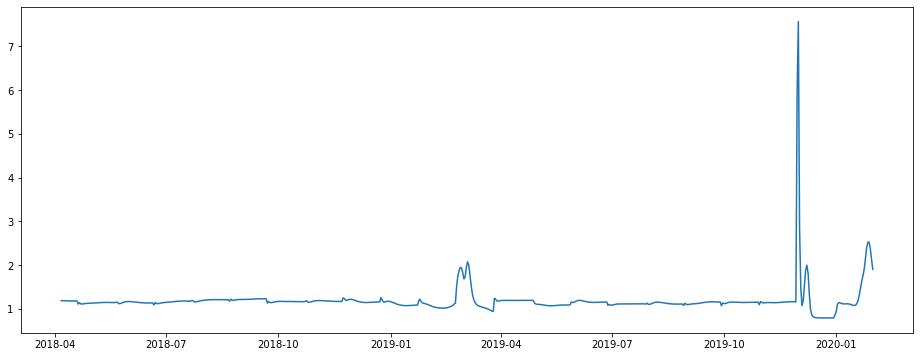

In [205]:
plt.figure(figsize=(16,6))
plt.plot(pred['Centro'])

In [97]:
data

,Date,Anchieta,Bangu,Barra da Tijuca,Botafogo,Campo Grande,Centro,Cidade de Deus,Complexo do Alemao,Copacabana,...,Portuaria,Ramos,Realengo,Rio Comprido,Rocinha,Santa Cruz,Santa Teresa,Sao Cristovao,Tijuca,Vila Isabel
0,2008-12-31,0.025522,0.009079,0.011007,0.000000,0.010674,0.066617,0.000000,0.000000,0.034691,...,0.000000,0.006877,0.026449,0.015969,0.000000,0.002863,0.057947,0.052674,0.006297,0.000000
1,2009-01-01,0.063703,0.047398,0.052289,0.057072,0.066402,0.103458,0.198661,0.000000,0.070387,...,0.029703,0.062168,0.046459,0.114169,0.014499,0.062111,0.000000,0.072225,0.012807,0.053311
2,2009-01-02,0.031852,0.015799,0.010458,0.009512,0.045433,0.206917,0.000000,0.000000,0.056310,...,0.000000,0.034538,0.025811,0.016310,0.000000,0.028232,0.192864,0.018056,0.025613,0.038079
3,2009-01-03,0.006370,0.040626,0.017430,0.014268,0.027959,0.103458,0.198661,0.000000,0.042232,...,0.059406,0.041445,0.041297,0.048929,0.014499,0.014116,0.096432,0.054169,0.019210,0.015232
4,2009-01-04,0.006370,0.029341,0.006972,0.014268,0.033201,0.206917,0.099331,0.000000,0.035194,...,0.000000,0.034538,0.036135,0.114169,0.000000,0.042349,0.000000,0.126394,0.012807,0.007616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2019-12-26,0.063110,0.017175,0.026825,0.033151,0.014695,0.582785,0.000000,0.000000,0.097973,...,0.072512,0.029047,0.051751,0.040399,0.000000,0.007407,0.000000,0.214890,0.015211,0.000000
4013,2019-12-27,0.031555,0.017175,0.028888,0.082877,0.016165,1.117004,0.000000,0.000000,0.073479,...,0.108767,0.036309,0.047438,0.060599,0.000000,0.007407,0.033653,0.071630,0.091264,0.050575
4014,2019-12-28,0.044177,0.034350,0.022698,0.049726,0.019104,0.777046,0.000000,0.000000,0.155123,...,0.072512,0.036309,0.038813,0.040399,0.000000,0.004938,0.067305,0.071630,0.022816,0.057800
4015,2019-12-29,0.056799,0.015028,0.018571,0.060776,0.010287,0.339958,0.062570,0.016988,0.236767,...,0.036256,0.029047,0.038813,0.080799,0.000000,0.012346,0.067305,0.071630,0.022816,0.028900
